In [1]:
%run -i ~/myLibrary/init.ipynb

/eos/user/n/nkarast/myLibrary/init.ipynb :: Ignoring warnings.


In [2]:
# For LHC Measurement Tools
import sys, os
BIN = os.path.expanduser("GianniLifetime/")
sys.path.append(BIN)
import LHCMeasurementTools.mystyle as ms
import LHCMeasurementTools.TimestampHelpers as th
import matplotlib.cm as cm

In [3]:
from matplotlib.ticker import MaxNLocator
import pjlsa
import pytimber

In [4]:
def getLPCSBFillList():
    df = pd.read_json("https://lpc.web.cern.ch/cgi-bin/fillTableReader.py?action=load&year=2018")['data'].apply(pd.Series)
    fill_list = df[(df['ta']==False)&(df['type']=='physics')].index.values.tolist()
    return fill_list

In [5]:
def getProjectFillList(blacklist = None):
    infolder      = "/eos/project/l/lhc-lumimod/LuminosityFollowUp/2018/procdata/"
    tmp_flist     = [int(x.split('/')[-1].split("_")[-1]) for x in glob.glob(infolder+"*")]
    if blacklist is None:
        blacklist = [6570, 6573, 6574, 6579, 6583, 6584, 6592, 6594, 6595, 6611, 6612, 6613, 6614, 6615, 6616, 6617, 6618, 6620, 6621, 6624, 6628, 6629, 6633, 6636, 6638, 6639, 
                6843, 6845, 6850, 6892, 6891, 6890, 6885, 6884, 6882, 6881, 6879, 6877, 6874, 6868, 6864, # 90m & VdM
                6912, 6911, 6909, # low mu
                6913, 
                 6966# BSRT Calibr
                ]
    overlap_flist_black = list(set(tmp_flist).intersection(blacklist))
    fill_list           = [fil for fil in tmp_flist if fil not in overlap_flist_black]
    return fill_list

In [6]:
def with_empty_slots(lifet_woBO_h, slots):

    mat = lifet_woBO_h.copy()
    outp = np.zeros((mat.shape[0], 3564), dtype=float)
    outp[:, slots]=mat

    return outp

In [7]:
def runSBFill(filln, dco, doPlot=False):
    '''
    given a fill produce some plots
    '''
    try:    
        ### Some fixed values:
        t_h_detail = 5
        folder = "/eos/project/l/lhc-lumimod/LuminosityFollowUp/2018/procdata/fill_%d"%filln

        try:
            with gzip.open(folder+'/fill_%d.pkl.gz'%filln, 'r') as fid:
                fill_data = pickle.load(fid)
            print('Loaded fill data.')
        except:
            print('Error Loading SB Data.')
            
        try:
            with gzip.open(folder+'/fill_%d_lumi_meas.pkl.gz'%filln, 'r') as fid:
                lumi_data = pickle.load(fid)
            print('Loaded lumi data.')
        except:
            print('Error Loading Lumi Data.')
            


        N_traces = len(fill_data['time_range'])
        n_dec = 10
        sigma_m2 = 80e-3*1e-28
        half_xang_obs_urad = 147


        # Get the time stamps & convert them
        t_stamps = fill_data['time_range']
        time_conv = th.TimeConverter(time_in='h', t_plot_tick_h=None, t_ref=t_stamps[0])
        tc = time_conv.from_unix


        # Get the data on chromaticity
        t_start_SB = t_stamps[0]
        t_stop_SB = t_stamps[-1]

        physics_BP_end = "PHYSICS-6.5TeV-30cm-120s-2018_V1@120_[END]"
        physics_BP = "PHYSICS-6.5TeV-30cm-120s-2018_V1"
        lsa = pjlsa.LSAClient()

        QP_offsets = {
        'LHCBEAM1/QPH': 15.-7.95981,
        'LHCBEAM1/QPV': 15.-20.1143,
        'LHCBEAM2/QPH': 15.-8.51945,
        'LHCBEAM2/QPV': 15.-18.32254,
        }

        chromaTrims_end = lsa.getTrims(parameter=['LHCBEAM1/QPH','LHCBEAM1/QPV','LHCBEAM2/QPH','LHCBEAM2/QPV'],
                                     beamprocess=physics_BP_end,
                                     start=t_start_SB-30*60, end=t_stop_SB)

        # Get the Octupole current
        ldb = pytimber.LoggingDB(source='ldb')
        data_timb = ldb.getScaled(['RPMBB.RR17.ROF.A12B1:I_MEAS', 'RPMBB.RR17.ROF.A12B2:I_MEAS'], t_start_SB, t_stop_SB, scaleAlgorithm='AVG', scaleInterval='MINUTE',scaleSize='1')


        figlist = []

        axslot = None
        axd    = None
        axd2   = None

        temp_dict = {filln : {1:{}, 2:{}}}

        for beam in [1,2]:
            tref_string=time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime(t_stamps[0]))


            slots = fill_data['slots_filled_coll'][beam]
            bint = fill_data['b_inten_interp_coll'][beam]
            


            # Calculate the loss rate from the FBCT and convert it into lifetime
            t_mat = np.dot(np.ones((len(slots), 1)), np.atleast_2d(t_stamps)).T
            loss_rate = -np.diff(bint, axis=0)/np.diff(t_mat, axis=0)
            lifet_h = 1/(loss_rate/bint[:-1,:])/3600.
            lifet_h[lifet_h<0]= 200

            print slots.shape, bint.shape, tmat.shape, loss_rate.shape
            
            # Calculate the total luminosity and find the burnoff loss rate
            tot_lumi = (lumi_data['ATLAS']['bunch_lumi']+lumi_data['CMS']['bunch_lumi'])[:-1, :]
            BO_loss_rate = tot_lumi*sigma_m2

            # Remove from the FBCT loss rate the calculated BO loss rate
            loss_rate_woBO = loss_rate-BO_loss_rate


            # Calculate the sum over all bunches loss rate for BO and other
            total_loss_rate_beam = np.sum(loss_rate, axis=1)
            total_loss_rate_BO = np.sum(BO_loss_rate, axis=1)


            # Calculate the burnoff corrected lifetime and do some quality cuts
            lifet_woBO_h = 1/(loss_rate_woBO/bint[:-1,:])/3600.
            lifet_woBO_h[lifet_woBO_h<0]= 200
            lifet_woBO_h[lifet_woBO_h>200]= 200
            lifet_woBO_h_allslots = with_empty_slots(lifet_woBO_h, slots) # this is for the bbb


            # Get octupole current
            thisoct = data_timb['RPMBB.RR17.ROF.A12B%d:I_MEAS'%beam]


            ############################################################################
            ### Plot the red/green plot with BO + other losses
            ############################################################################
            if doPlot:
                figtot = plt.figure(1000+beam, figsize=(8*1.3, 6))
                figtot.set_facecolor('w')
                axtotl = plt.subplot(111)
                axtotl.fill_between(x=tc(t_stamps[:-1]), y1=total_loss_rate_BO, color='g', alpha=0.5, label='Burn-off')
                axtotl.fill_between(x=tc(t_stamps[:-1]), y1=total_loss_rate_beam, y2=total_loss_rate_BO, color='r', alpha=0.5, label='Other losses')
                axtotl.plot(tc(t_stamps[:-1]), total_loss_rate_beam, lw=2, color='k', label='Total loss-rate')
                axtotl.set_xlabel('Time [h]')
                axtotl.set_ylabel('Loss rate [p/s]')
                axtotl.legend(loc='upper right')
                axtotl.grid('on')
                figtot.suptitle('Fill %d SB loss rate decompoition B%d\nSB started on %s\n'%(filln, beam, tref_string))
                figlist.append(figtot)



            ##################################################################################################################
            ### This is the bbb plot with the BO corrected lifetime, luminosity, xing, chroma & octupoles subplots
            ##################################################################################################################
            if doPlot:
                fig  = plt.figure(beam, figsize=(8*1.8,6*1.3))
                fig.set_facecolor('w')
                axlt = plt.subplot2grid(shape=(5, 5), loc=(0, 1), colspan=3, rowspan=4, sharex=axslot)
                cc   = axlt.pcolormesh(np.arange(3564), tc(t_stamps), lifet_woBO_h_allslots, cmap=cm.jet_r, vmin=0, vmax=120)

                axcb = plt.subplot2grid(shape=(5, 5), loc=(4, 1), colspan=3, rowspan=1)
                plt.colorbar(cc, cax=axcb, label='Lifetime (BO corrected) [h]', orientation='horizontal')
                axlt.set_xlabel('25ns slot')

                axslot = axlt
                axslot.set_xlim(0, 3500)

                ax1 = plt.subplot2grid(shape=(5, 5), loc=(0, 0), colspan=1, rowspan=4, sharey=axlt)
                ax1.step(fill_data['xing_angle'][1]*1e6/2, tc(t_stamps), lw=2.)
                ax1.set_xlim(120, 170)
                ax1.set_xlabel('Half-crossing angle [$\mathrm{\mu}$rad]')
                ax1.set_ylabel('Time [h]')
                ax1.xaxis.label.set_color('b')
                ax1.tick_params(axis='x', colors='b')
                ax1.grid('on')

                axlumi = ax1.twiny()
                axlumi.plot(0.5*np.sum(lumi_data['CMS']['bunch_lumi']+lumi_data['ATLAS']['bunch_lumi'],axis=1)/1e34*1e-4, tc(t_stamps), 'r', lw=2.)
                axlumi.set_xlabel('Avg. Lumi [$10^{34}$ Hz/cm$^2$]')
                axlumi.xaxis.label.set_color('r')
                axlumi.tick_params(axis='x', colors='r')
                axlumi.xaxis.set_major_locator(MaxNLocator(5))
                plt.setp(axlumi.get_xticklabels(), fontsize=11)

                axqp = plt.subplot2grid(shape=(5, 5), loc=(0, 4), colspan=1, rowspan=4, sharey=axlt)
                for plane, styl in zip(['H', 'V'], ['--', '-']):
                    parname = 'LHCBEAM%d/QP'%beam + plane
                    thistrim = chromaTrims_end[parname]
                    thistrim.data.append(thistrim.data[-1])
                    thistrim.time.append(t_stop_SB)
                    axqp.step(np.array(thistrim.data)+QP_offsets[parname], tc(thistrim.time), ls=styl, lw=2, color = 'k')
                axqp.set_xlim(0, 16)
                setAxisMaxLocator(axqp, 'x', 10)
                axqp.set_xlabel('Chromaticity')
                axqp.grid('on')

                axoct = axqp.twiny()
                #thisoct = data_timb['RPMBB.RR17.ROD.A12B%d:I_MEAS'%beam]
                axoct.plot(thisoct[1], tc(thisoct[0]), 'r', lw=2)
#                 axoct.set_xlim(-600, -300)
                axoct.xaxis.label.set_color('r')
                axoct.tick_params(axis='x', colors='r')
                axoct.xaxis.set_major_locator(MaxNLocator(5))
                axoct.set_xlabel('$I_{\mathrm{MO}}$ [A]')
                axoct.set_ylim(bottom=0)
                plt.setp(axoct.get_xticklabels(), fontsize=11)

                fig.subplots_adjust(right=.95, left=.05, bottom=.12, top=.81, hspace = 1)
                fig.suptitle('Fill %d SB BurnOff corrected lifetime B%d\nSB started on %s\n'%(filln, beam, tref_string))
                figlist.append(fig)



            # Calculate some stuff around the observed crossing angle:        
            i_detail   = np.argmin(np.abs(half_xang_obs_urad - fill_data['xing_angle'][1]/2*1e6))
            t_h_detail = tc(t_stamps)[i_detail]

            mdict = { 'xing':[], 
                                       'burnoffCorrectedLifetime':[], 
                                       'burnoffCorrectedLossRate':[], 
                                       'burnoffLifetime': [], 
                                       'burnoffLossRate' :[], 
                                       'octupoles':[],
            } 


            if t_h_detail<tc(t_stamps)[-1]:

                ## Some calculations on BO lifetimes 
                i_plot = np.argmin(np.abs(t_h_detail-tc(t_stamps)))
                BO_lr_det = with_empty_slots(BO_loss_rate, slots)[i_plot, :]
                lr_det = with_empty_slots(loss_rate, slots)[i_plot, :]
                lt_BO_avg = 1./(np.sum(BO_lr_det)/np.sum(bint[i_plot]))/3600.         # burn-off lifetime
                lt_other = 1./(np.sum(lr_det-BO_lr_det)/np.sum(bint[i_plot]))/3600.   # burn-off corrected lifetime



                if doPlot:
                    figd = plt.figure(100+beam, figsize=(8*1.4,6))
                    figd.set_facecolor('w')
                    axd = figd.add_subplot(111, sharex=axslot, sharey=axd)


                    ## Plot
                    plt.fill_between(np.arange(3564),BO_lr_det, color='green', alpha=0.6, label='Burn off')
                    plt.fill_between(np.arange(3564), BO_lr_det, lr_det, color='red', alpha=.6, label='Additional losses')
                    ms.sciy()

                    axd.set_ylabel('Loss rate [p/s]')
                    axd.set_xlabel('25 ns slot')
                    axd.legend(loc='lower right', prop={'size':14})
                    axd.set_xlim(0,3500)
                    axd.set_ylim(bottom=0)
                    axd.grid('on')
                    figd.subplots_adjust(right=.94, left=.1, bottom=.12, top=.86)
                    figd.suptitle('Fill %d SB Loss Rate at %.1fh for B%d\nSB started on %s\n'%(filln, t_h_detail, beam, tref_string))
                    figlist.append(figd)


                    #### ------ 
                    figd2 = plt.figure(200+beam, figsize=(8*1.4,6))
                    figd2.set_facecolor('w')
                    axd2 = figd2.add_subplot(111, sharex=axslot, sharey=axd2)

                    axd2.plot(np.arange(3564), BO_lr_det, 'b', lw=2, label='Burn-off ($\\tau$=%.1fh)'%lt_BO_avg)
                    axd2.plot(np.arange(3564), lr_det-BO_lr_det, 'r', lw=2, label='Other losses ($\\tau$=%.1fh)'%lt_other)
                    ms.sciy()
                    axd2.set_ylabel('Loss rate [p/s]')
                    axd2.set_xlabel('25 ns slot')
                    axd2.legend(loc='upper right', prop={'size':14})
                    axd2.set_xlim(0,3500)
                    axd2.set_ylim(bottom=0, top=1.4e6)
                    axd2.grid('on')
                    figd2.subplots_adjust(right=.94, left=.1, bottom=.12, top=.86)
                    figd2.suptitle('Fill %d Loss Rates at %.1fh for B%d Xang %.0furad\nSB started on %s\n'%(filln, t_h_detail, beam, fill_data['xing_angle'][1][i_plot]/2*1e6, tref_string))
                    figlist.append(figd2)

                mdict['xing'].append(fill_data['xing_angle'][1][i_plot]/2.0*1e6)
                mdict['burnoffCorrectedLifetime'].append(lt_other)
                mdict['burnoffCorrectedLossRate'].append(np.sum(lr_det-BO_lr_det))
                mdict['burnoffLifetime'].append(lt_BO_avg)
                mdict['burnoffLossRate'].append(np.sum(BO_lr_det))
            else:
                mdict['xing'].append(np.nan)
                mdict['burnoffCorrectedLifetime'].append(np.nan)
                mdict['burnoffCorrectedLossRate'].append(np.nan)
                mdict['burnoffLifetime'].append(ltnp.nan_BO_avg)
                mdict['burnoffLossRate'].append(np.nan)
                

            mdict['octupoles'].append(np.abs(thisoct[1])[0])
            #temp_dict[filln].update(temp_dict[filln][beam])


                #with open('avglifet_SB/avg_lifet_fill%d_beam%d_%.1furad.txt'%(filln, beam, fill_data['xing_angle'][1][i_plot]/2*1e6), 'w') as fid:
                #    fid.write('%.3f %.3f'%(lt_other, lt_BO_avg))

            temp_dict[filln][beam].update(mdict)
        dco.update(temp_dict)
        ff = './results_stablebeams/'
        #[fg.savefig(ff+'/'+fg._suptitle.get_text().split('\n')[0].replace(' ','_')+'.png', dpi=200) for fg in figlist]
        if doPlot:
            axslot.set_xlim(770, 1270)

    except:
        return

In [8]:
dco = {}

In [9]:
runSBFill(7270, dco, True)

Loaded fill data.
Loaded lumi data.


(2544,) (180, 2544)


In [10]:
dco

{}

In [11]:
def runSummary(filename='SummaryBoffCorrLF.pkl.gz', mfillList = None):
    
    if os.path.exists(filename):
        print("Filename {} exists, opening....".format(filename))
        with gzip.open(filename, 'rb') as fid:
            dco = pickle.load(fid)
            
        if mfillList is None:
            #lpc_fill_list = getLPCSBFillList()
            project_fill_list = getProjectFillList()
            myFillList = [x for x in project_fill_list if x not in dco.keys()]
        else:
            myFillList = [x for x in mfillList if x not in dco.keys()]
        
    else:
        print("Creating new dictionary...")
        dco = {}
        if mfillList is None:
            myFillList = getProjectFillList()
        else:
            myFillList = [x for x in mfillList if x not in dco.keys()]
        
    
    for filln in myFillList:
        print("working on fill: {}".format(filln))
        runSBFill(filln, dco, doPlot=False)
    
    
        with gzip.open(filename, 'wb') as fid:
            pickle.dump(dco, fid)
    
    print('done')

In [12]:
runSummary()

Filename SummaryBoffCorrLF.pkl.gz exists, opening....
working on fill: 6724
Loaded fill data.
Loaded lumi data.


working on fill: 6731
Loaded fill data.
Loaded lumi data.


working on fill: 6751
Loaded fill data.
Loaded lumi data.


working on fill: 6752
Loaded fill data.
Loaded lumi data.


working on fill: 6755
Loaded fill data.
Loaded lumi data.


working on fill: 6761
Loaded fill data.
Error Loading Lumi Data.


working on fill: 6768
Loaded fill data.
Loaded lumi data.


working on fill: 6819
Error Loading SB Data.
Error Loading Lumi Data.
working on fill: 6925
Loaded fill data.
Loaded lumi data.


working on fill: 6944
Loaded fill data.
Loaded lumi data.


working on fill: 6946
Loaded fill data.
Loaded lumi data.


working on fill: 7058
Error Loading SB Data.
Error Loading Lumi Data.
working on fill: 7063
Loaded fill data.
Error Loading Lumi Data.


working on fill: 7078
Loaded fill data.
Loaded lumi data.


working on fill: 7083
Loaded fill data.
Error Loading Lumi Data.


working on fill: 7087
Loaded fill data.
Error Loading Lumi Data.


working on fill: 7088
Loaded fill data.
Loaded lumi data.


working on fill: 7109
Loaded fill data.
Loaded lumi data.


working on fill: 7253
Error Loading SB Data.
Error Loading Lumi Data.
working on fill: 7256
Error Loading SB Data.
Error Loading Lumi Data.
working on fill: 7299
Loaded fill data.
Error Loading Lumi Data.


working on fill: 7300
Loaded fill data.
Error Loading Lumi Data.


working on fill: 7317
Loaded fill data.
Loaded lumi data.


working on fill: 7324
Loaded fill data.
Error Loading Lumi Data.


working on fill: 7331
Loaded fill data.
Loaded lumi data.


working on fill: 7333
Loaded fill data.
Loaded lumi data.


working on fill: 7334
Loaded fill data.
Loaded lumi data.


working on fill: 7358
Loaded fill data.
Error Loading Lumi Data.


done


# Πλοττινγ 
### (I found it funny... oh, drugs...)

In [16]:
filename = 'SummaryBoffCorrLF.pkl.gz'
with gzip.open(filename, 'rb') as fid:
    data = pickle.load(fid)

In [17]:
additional_blacklist = [6584, 6699, 6819, 6843, 6847, 6850, 6864, 6868, 6877, 6879, 6881, 6882, 6884, 6885, 6890, 6891, 6892, 6901, 6913, 6919, 6929, 6966, 6998, 7003, 7005, 7188, 7211, 7212, 7220, 7308, 7304, 7300, 7299, 7220, 7212, 7211, 7188, 7005, 7358]

In [18]:
temp_fill_list = np.array(sorted(data.keys()))
fill_list = [x for x in temp_fill_list if x not in additional_blacklist]
fill_list = np.array(fill_list)
print len(fill_list)
fill_list

155


array([6640, 6641, 6642, 6643, 6645, 6646, 6648, 6650, 6654, 6659, 6662,
       6663, 6666, 6672, 6674, 6675, 6677, 6681, 6683, 6688, 6690, 6693,
       6694, 6696, 6700, 6702, 6706, 6709, 6710, 6711, 6712, 6714, 6719,
       6729, 6733, 6737, 6738, 6741, 6744, 6747, 6749, 6757, 6759, 6762,
       6763, 6770, 6772, 6773, 6774, 6776, 6778, 6854, 6858, 6860, 6904,
       6921, 6923, 6924, 6927, 6931, 6939, 6940, 6942, 6953, 6956, 6957,
       6960, 6961, 7006, 7008, 7013, 7017, 7018, 7020, 7024, 7026, 7031,
       7033, 7035, 7036, 7037, 7039, 7040, 7042, 7043, 7045, 7047, 7048,
       7052, 7053, 7054, 7055, 7056, 7061, 7065, 7069, 7080, 7090, 7091,
       7092, 7095, 7097, 7098, 7099, 7101, 7105, 7108, 7110, 7112, 7114,
       7117, 7118, 7120, 7122, 7123, 7124, 7125, 7127, 7128, 7131, 7132,
       7133, 7135, 7137, 7139, 7142, 7144, 7145, 7213, 7217, 7218, 7221,
       7234, 7236, 7239, 7240, 7242, 7245, 7252, 7259, 7264, 7265, 7266,
       7270, 7271, 7274, 7309, 7310, 7314, 7315, 73

In [19]:
# Clear depending on the xing in the range of 146-148urad
xing = []
for x in fill_list:
    xing.append(data[x][1]['xing'][0])
xing = np.array(xing)

In [20]:
n_fill_list = fill_list[np.logical_and(xing<=148., xing>=146)]
fill_list = n_fill_list
print len(fill_list)
fill_list

126


array([6640, 6641, 6642, 6648, 6654, 6662, 6663, 6666, 6674, 6675, 6677,
       6681, 6693, 6694, 6696, 6700, 6702, 6706, 6709, 6710, 6711, 6712,
       6714, 6719, 6729, 6733, 6738, 6741, 6744, 6749, 6757, 6759, 6763,
       6770, 6772, 6773, 6774, 6778, 6860, 6904, 6923, 6924, 6931, 6939,
       6940, 6942, 6953, 6956, 6957, 6960, 6961, 7006, 7008, 7013, 7017,
       7018, 7020, 7024, 7031, 7033, 7036, 7037, 7039, 7040, 7042, 7045,
       7047, 7048, 7052, 7053, 7055, 7056, 7061, 7065, 7069, 7080, 7090,
       7091, 7092, 7095, 7097, 7098, 7101, 7105, 7108, 7110, 7117, 7118,
       7120, 7122, 7123, 7124, 7125, 7127, 7128, 7131, 7132, 7133, 7135,
       7137, 7139, 7144, 7145, 7217, 7218, 7221, 7234, 7236, 7239, 7240,
       7242, 7245, 7252, 7259, 7264, 7270, 7274, 7309, 7310, 7314, 7315,
       7320, 7321, 7328, 7333, 7334])

In [21]:
octupoles = []
for x in fill_list:
    octupoles.append(data[x][1]['octupoles'][0])

octupoles = np.array(octupoles)
octupoles

array([451.98, 451.98, 451.98, 451.98, 451.98, 414.32, 395.49, 395.49,
       376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65,
       376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 338.99,
       338.99, 301.32, 301.32, 301.32, 301.32, 301.32, 301.32, 301.32,
       301.32, 301.32, 301.32, 301.32, 301.32, 301.32, 376.65, 376.65,
       376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65,
       376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65,
       376.65, 376.65, 376.65,    nan, 376.65, 376.65, 376.65, 376.65,
       376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 357.82,
       376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65,
       376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65,
       376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65,
       376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65, 376.65,
       376.65, 320.15,    nan, 338.99, 338.99, 338.99, 338.99, 338.99,
      

In [22]:
lf_b1 = []
lf_b2 = []
for x in fill_list:
    lf_b1.append(data[x][1]['burnoffCorrectedLifetime'][0])
    lf_b2.append(data[x][2]['burnoffCorrectedLifetime'][0])
lf_b1 = np.array(lf_b1)
lf_b2 = np.array(lf_b2)

### --- put to nan negative values
lf_b1[lf_b1<0] = np.nan
lf_b2[lf_b2<0] = np.nan

In [23]:
# lfdf = pd.DataFrame()
# lfdf['fill'] = fill_list.tolist()
# lfdf['octupoles'] = octupoles.tolist()
# lfdf['B1_LF']= lf_b1.tolist()
# lfdf['B2_LF']= lf_b2.tolist()
# lfdf

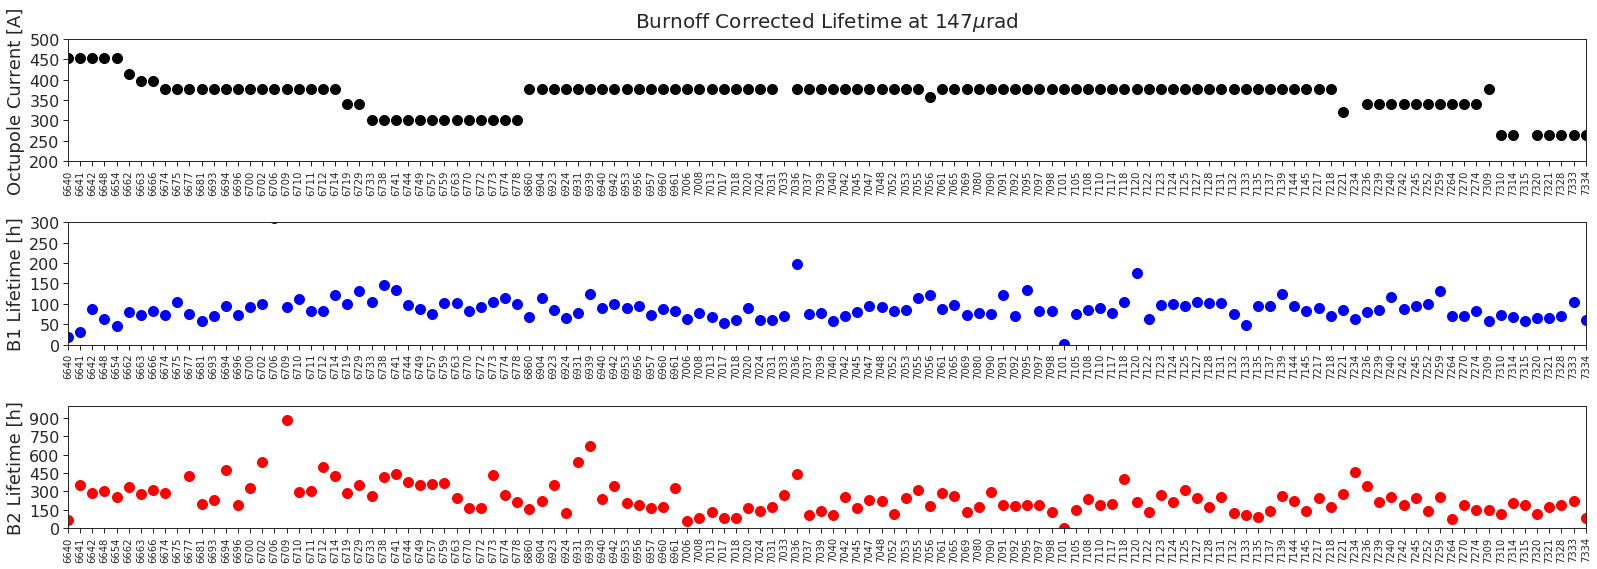

In [26]:
f   = plt.figure(1, figsize=(16*1.7,9))


ax1 = plt.subplot(311)
ax1.plot(np.arange(len(fill_list)), octupoles, 'ko', markersize=10)
ax1.set_xlim(0, len(fill_list)-1)
plt.xticks(np.arange(len(fill_list)), fill_list, rotation='vertical')
ax1.set_ylabel("Octupole Current [A]")

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(np.arange(len(fill_list)), lf_b1, 'bo', markersize=10)
ax2.set_xlim(0, len(fill_list)-1)
plt.xticks(np.arange(len(fill_list)), fill_list, rotation='vertical')
ax2.set_ylabel("B1 Lifetime [h]")


ax3 = plt.subplot(313, sharex=ax1)
ax3.plot(np.arange(len(fill_list)), lf_b2, 'ro', markersize=10)
ax3.set_xlim(0, len(fill_list)-1)
plt.xticks(np.arange(len(fill_list)), fill_list, rotation='vertical')
ax3.set_ylabel("B2 Lifetime [h]")

# ax1.axvline(np.arange(len(fill_list))[-4], c='k', ls=':')
# ax2.axvline(np.arange(len(fill_list))[-4], c='b', ls=':')
# ax3.axvline(np.arange(len(fill_list))[-4], c='r', ls=':')


plt.setp(ax1.get_xticklabels(), fontsize=10)
plt.setp(ax2.get_xticklabels(), fontsize=10)
plt.setp(ax3.get_xticklabels(), fontsize=10)

setAxisMaxLocator(ax1, 'y', 7)
setAxisMaxLocator(ax2, 'y', 7)
setAxisMaxLocator(ax3, 'y', 7)

ax1.set_ylim(200, 500)
ax2.set_ylim(0,300)
ax3.set_ylim(0,1000)
# ax2.set_ylim(50,100)
# ax3.set_ylim(150,250)


ax1.set_title("Burnoff Corrected Lifetime at 147$\mu$rad", fontsize=20, y=1.05)
f.subplots_adjust(hspace=0.5)

In [28]:
print("Up to TS1:")
print("------------------------")
print("B1 : {} +\- {}".format(np.nanmean(lf_b1[n_fill_list<6800]), np.nanstd(lf_b1[n_fill_list<6800])))
print("B2 : {} +\- {}".format(np.nanmean(lf_b2[n_fill_list<6800]), np.nanstd(lf_b2[n_fill_list<6800])))
print("------------------------\n")
print("From TS1 to TS2:")
print("------------------------")
print("B1 : {} +\- {}".format(np.nanmean(lf_b1[np.logical_and(n_fill_list<7150, n_fill_list>6800)]), np.nanstd(lf_b1[np.logical_and(n_fill_list<7150, n_fill_list>6800)])))
print("B2 : {} +\- {}".format(np.nanmean(lf_b2[np.logical_and(n_fill_list<7150, n_fill_list>6800)]), np.nanstd(lf_b2[np.logical_and(n_fill_list<7150, n_fill_list>6800)])))
print("After TS2:")
print("------------------------")
print("B1 : {} +\- {}".format(np.nanmean(lf_b1[n_fill_list>7150]), np.nanstd(lf_b1[n_fill_list>7150])))
print("B2 : {} +\- {}".format(np.nanmean(lf_b2[n_fill_list>7150]), np.nanstd(lf_b2[n_fill_list>7150])))

Up to TS1:
------------------------
B1 : 94.4343872523 +\- 43.6986420194
B2 : 360.065071823 +\- 214.276827632
------------------------

From TS1 to TS2:
------------------------
B1 : 87.089610182 +\- 27.4107912817
B2 : 206.978670565 +\- 109.126790946
After TS2:
------------------------
B1 : 80.0451640115 +\- 18.6076120595
B2 : 200.622845524 +\- 82.8759968206
